## imports

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
import os
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform, cosine, euclidean, mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from PIL import Image
from IPython.core.debugger import set_trace
import nethook as nethook
import scipy.io as sio
from tqdm import tqdm
import time
import importlib
import rsatools as rsa
import nnutils as utils
import torchvision.datasets as datasets
from floc_selectivity import floc_selectivity

importlib.reload(rsa)
importlib.reload(utils)

<module 'nnutils' from '/home/jacobpri/git/RotspaceIT/notebooks/nnutils.py'>

In [115]:
## hyperparameters
arch = 'cornet-z'
trained_on = 'object'
imageset = 'vpnl-floc'
img_dim = 56
batch_size = 512
save_as = '.npy'
#save_layer_rdvs = True
#rdv_dist = 'correlation'
overwrite = False
verbose = True

In [116]:
## directory management

home_dir = '/home/jacobpri/git/RotspaceIT/'

# target directory for loading activations
activation_loaddir = join(home_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise RDVs
#rdv_savedir = join(home_dir,'data','d02_modeling','rdvs')

# folder of trained model weights
#weight_dir = join(home_dir,'data','d02_modeling','weights')

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + trained_on

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_loaddir = join(activation_loaddir, load_arch, d, imageset, 'dim' + str(img_dim))
        #rdv_savedir = join(rdv_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break

if found is False:
    raise ValueError('image set not found')   

# create savedir if it doesn't yet exist 
#os.makedirs(activation_savedir, exist_ok=True)
#os.makedirs(rdv_savedir, exist_ok=True)

print("imageset dir %s\n" % imageset_dir)
#print("weight dir %s\n" % weight_dir)
print("activation load destination: %s\n" % activation_loaddir)
#print("rdv save destination: %s\n" % rdv_savedir)

assert(exists(activation_loaddir))
assert(exists(imageset_dir))
#assert(exists(weight_dir))
assert(save_as == '.npy' or save_as == '.mat')

imageset dir /home/jacobpri/git/RotspaceIT/imagesets/localizer/vpnl-floc

activation load destination: /home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/cornet-z-object/localizer/vpnl-floc/dim56



In [117]:
layer_names_fn = join(activation_loaddir, 'lay_names_user_fmt_batchsize-' + str(batch_size) + '.npy')
assert(exists(layer_names_fn))

layer_names = np.load(layer_names_fn)

all_types = ['conv','relu','pool','norm','drop','fc','downsample','identity','flatten']
includes = all_types #['conv','fc','relu']#all_types#['relu','conv','fc']#all_types#['conv','fc','relu']#all_types#['conv','relu','fc','relu','norm','drop','pool','flatten']#all_types#['conv','fc']

layers_to_load = []

for i in range(len(layer_names)):
    if any(s in layer_names[i] for s in includes):
        layers_to_load.append(layer_names[i])

print(layers_to_load,'\n')
print('%d layers chosen' % len(layers_to_load))

['1_conv1', '2_relu1', '3_maxpool1', '4_identity1', '5_conv2', '6_relu2', '7_maxpool2', '8_identity2', '9_conv3', '10_relu3', '11_maxpool3', '12_identity3', '13_conv4', '14_relu4', '15_maxpool4', '16_identity4', '17_avgpool4', '18_flatten4', '19_fc5', '20_identity5'] 

20 layers chosen


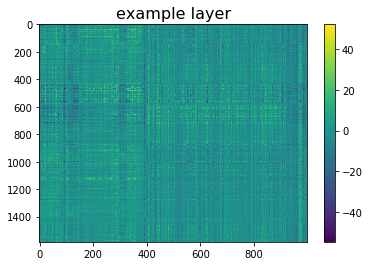

In [119]:
## load batched activations, reshape to 2d, concatenate

# test on a single layer
Y = utils.load_batched_activations(activation_loaddir, ['19_fc5'], batch_size)

rsa.plot_matrix(Y,tl = 'example layer',fontsize=16)

In [125]:
## organize category indices

dataset = datasets.ImageFolder(root = imageset_dir)

# print some info -> verify correct # imgs, etc
categ_idx = np.array(dataset.targets)

if imageset == 'vpnl-floc':
    floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
    floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
    floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
    categ_nimg = 144

    categ_idx = np.repeat(floc_categ_domain_ref,categ_nimg)
else:
    floc_domains = dataset.classes

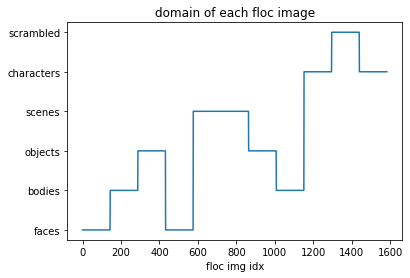

In [127]:
## visualize, for sanity
plt.figure()
plt.plot(categ_idx)
plt.yticks(np.arange(len(floc_domains)),floc_domains);
plt.xlabel('floc img idx')
plt.title('domain of each floc image');

In [128]:
## run deepnet floc experiment, returning a dict with each layer's pref dict
pref_dicts = dict()

with tqdm(total=100,desc='Conducting deepnet floc experiments') as pbar:
    for layer in layers_to_load:
        
        print(layer)
        time.sleep(0.1) 
        
        Y = utils.load_batched_activations(activation_loaddir, layer, batch_size)
        
        pref_dicts[layer] = floc_selectivity(Y, categ_idx)
        
        pbar.update(100/len(layers_to_load))


Conducting deepnet floc experiments:   0%|          | 0/100 [00:00<?, ?it/s]

1_conv1


Conducting deepnet floc experiments:   5%|▌         | 5.0/100 [00:09<02:52,  1.81s/it]

2_relu1


Conducting deepnet floc experiments:  10%|█         | 10.0/100 [00:18<02:45,  1.84s/it]

3_maxpool1


Conducting deepnet floc experiments:  15%|█▌        | 15.0/100 [00:20<01:59,  1.40s/it]

4_identity1


Conducting deepnet floc experiments:  20%|██        | 20.0/100 [00:22<01:26,  1.08s/it]

5_conv2


Conducting deepnet floc experiments:  25%|██▌       | 25.0/100 [00:25<01:11,  1.06it/s]

6_relu2


Conducting deepnet floc experiments:  30%|███       | 30.0/100 [00:28<00:58,  1.20it/s]

7_maxpool2


Conducting deepnet floc experiments:  35%|███▌      | 35.0/100 [00:29<00:41,  1.57it/s]

8_identity2


Conducting deepnet floc experiments:  40%|████      | 40.0/100 [00:29<00:29,  2.01it/s]

9_conv3


Conducting deepnet floc experiments:  45%|████▌     | 45.0/100 [00:31<00:24,  2.26it/s]

10_relu3


Conducting deepnet floc experiments:  50%|█████     | 50.0/100 [00:33<00:20,  2.46it/s]

11_maxpool3


Conducting deepnet floc experiments:  55%|█████▌    | 55.0/100 [00:33<00:14,  3.12it/s]

12_identity3


Conducting deepnet floc experiments:  60%|██████    | 60.0/100 [00:34<00:10,  3.80it/s]

13_conv4


Conducting deepnet floc experiments:  65%|██████▌   | 65.0/100 [00:35<00:08,  3.95it/s]

14_relu4


Conducting deepnet floc experiments:  70%|███████   | 70.0/100 [00:36<00:07,  4.19it/s]

15_maxpool4


Conducting deepnet floc experiments:  75%|███████▌  | 75.0/100 [00:36<00:04,  5.34it/s]

16_identity4


Conducting deepnet floc experiments:  85%|████████▌ | 85.0/100 [00:37<00:01,  8.60it/s]

17_avgpool4
18_flatten4


Conducting deepnet floc experiments:  90%|█████████ | 90.0/100 [00:37<00:00, 10.79it/s]

19_fc5


Conducting deepnet floc experiments:  95%|█████████▌| 95.0/100 [00:37<00:00, 12.73it/s]

20_identity5


Conducting deepnet floc experiments: 100%|██████████| 100.0/100 [00:38<00:00,  2.63it/s]


In [9]:
## save preference dict for a given locset/model/param combination

In [129]:
print(pref_dicts[layer]['domain_counts'])

[164, 5, 3, 44, 3, 51]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

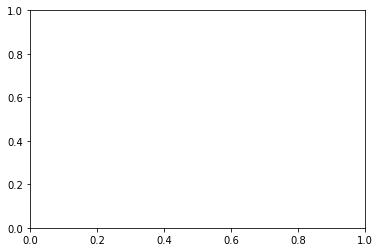

In [130]:
## plots
# selective neurons by domain
plt.figure()
plt.bar(np.arange(len(dataset.classes)),pref_dicts['5_conv2']['domain_counts'])
plt.xticks(np.arange(len(dataset.classes)),dataset.classes,rotation=90);
plt.ylabel('# neurons')
plt.title('# %s selective neurons by domain' % layer);

(20, 6)


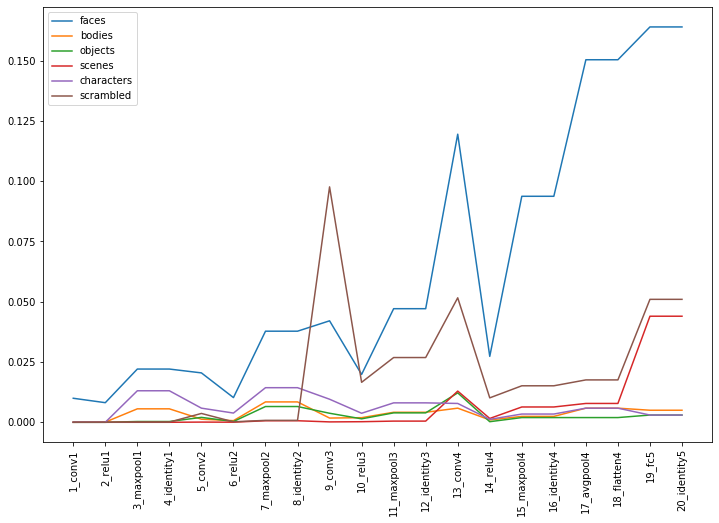

In [132]:
domain_props = []
for i in range(len(layers_to_load)):
    domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
domain_props = np.vstack(domain_props)
print(domain_props.shape)

plt.figure(figsize=(12,8))
plt.plot(domain_props);
plt.legend(floc_domains)
plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);